## Test Silent Drift

In [ ]:
import pandas as pd
import numpy as np
import glob
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.parquet as pq
import tensorflow as tf
from tensorflow.keras import mixed_precision
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

#CONFIGURAZIONE GPU
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        policy = mixed_precision.Policy('mixed_float16')
        mixed_precision.set_global_policy(policy)
        print("GPU e Mixed Precision Attivate.")
    except RuntimeError as e:
        print(e)

#ATH
INPUT_DIR = '../Pre-Elaborazione Dati/Dataset' 
SCALER_PATH = 'scaler.joblib' 
MODEL_PATH = 'lstm_autoencoder_best.keras' 

COLONNE_FEATURES = ['Latitude', 'Longitude', 'SOG', 'COG']
WINDOW_SIZE = 30  
BATCH_SIZE = 64 

# Carichiamo SOLO i file di TEST
all_files = sorted(glob.glob(os.path.join(INPUT_DIR, '*.parquet')))
TEST_FILES = all_files[20:24]
print(f"File di Test Caricati")

2025-11-21 13:55:19.917274: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-21 13:55:19.952705: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-21 13:55:20.813499: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


GPU e Mixed Precision Attivate.
File di Test Caricati


##### Funzioni

In [2]:
def create_windows(data_np, window_size):
    windows = []
    for i in range(len(data_np) - window_size + 1):
        windows.append(data_np[i : i + window_size])
    return windows

def data_generator_v(file_paths, scaler, features, window_size, batch_size, shuffle_files=False):
    
    file_buffer = {} 
    window_buffer = [] 
    CHUNK_SIZE_ROWS = 500_000

    while True:
        if shuffle_files:
             # Shuffle disattivato forzatamente per garantire la sequenzialità
            shuffle_files = False 
            
        for file_path in file_paths:
            chunk_buffer = {}
            try:
                pf = pq.ParquetFile(file_path)
                for batch in pf.iter_batches(batch_size=CHUNK_SIZE_ROWS, columns=features + ['TrajectoryID']):
                    df_chunk = batch.to_pandas()
                    df_chunk[features] = scaler.transform(df_chunk[features])
                    next_chunk_buffer = {}
                    
                    for tid, group in df_chunk.groupby('TrajectoryID'):
                        if tid in chunk_buffer:
                            trajectory_data = pd.concat([chunk_buffer.pop(tid), group])
                        else:
                            trajectory_data = group
                        
                        if tid in file_buffer:
                            trajectory_data = pd.concat([file_buffer.pop(tid), trajectory_data])
                        
                        # Se la traiettoria tocca la fine del chunk, bufferizzala
                        if trajectory_data.iloc[-1].name == df_chunk.iloc[-1].name:
                            next_chunk_buffer[tid] = trajectory_data
                            continue 
                            
                        if len(trajectory_data) < window_size:
                            continue 
                            
                        trajectory_np = trajectory_data[features].to_numpy()
                        new_windows = create_windows(trajectory_np, window_size)
                        window_buffer.extend(new_windows)
                        
                        next_chunk_buffer[tid] = trajectory_data.iloc[-(window_size - 1):]

                        while len(window_buffer) >= batch_size:
                            batch_to_yield = window_buffer[:batch_size]
                            window_buffer = window_buffer[batch_size:]
                            yield (np.array(batch_to_yield), np.array(batch_to_yield))
                    
                    chunk_buffer = next_chunk_buffer
                file_buffer = chunk_buffer
            except Exception as e:
                print(f"\nErrore lettura {file_path}: {e}")
                continue
print("Funzioni definite")

Funzioni definite


##### Caricamento risorse

In [3]:
# Carica Scaler e Modello
scaler = joblib.load(SCALER_PATH)
model = tf.keras.models.load_model(MODEL_PATH)
print("Modello e Scaler caricati.")

# Inizializza il generatore pulito
test_gen = data_generator_v(TEST_FILES, scaler, COLONNE_FEATURES, WINDOW_SIZE, BATCH_SIZE, shuffle_files=False)

I0000 00:00:1763729799.090837    9999 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3060 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Modello e Scaler caricati.


#### Funzione di attacco Silent Drift

In [4]:
def apply_silent_drift_attack(batch_clean, drift_rate=0.05):

    """
        drift_rate: Intensità del drift (cumulativo per ogni step)
    """
    batch_attacked = batch_clean.copy()
    
    # Creiamo un vettore di drift crescente
    steps = np.arange(batch_clean.shape[1]) # 0 a 29
    drift_vector = steps * drift_rate
    
    # Applichiamo il drift a Latitudine (0) e Longitudine (1)
    # Simuliamo una deriva diagonale (Nord-Est)
    # Usiamo il broadcasting di numpy per applicarlo a tutto il batch
    
    # Lat = Lat + drift
    batch_attacked[:, :, 0] += drift_vector
    # Lon = Lon + drift
    batch_attacked[:, :, 1] += drift_vector
    
    return batch_attacked
print("Funzione di attacco Silent Drift definita.")

Funzione di attacco Silent Drift definita.


#### Creazione dataset misto

In [16]:
X_test_mixed = []
y_true = [] 

NUM_BATCHES = 10000 

# Parametro di Drift: 0.05 è un drift medio sui dati normalizzati.
# Se è troppo basso, l'attacco è invisibile. Se troppo alto, è palese.
DRIFT_INTENSITY = 0.05 

for _ in range(NUM_BATCHES):
    try:
        clean_batch, _ = next(test_gen)
    except StopIteration:
        break
        
    # Creiamo l'attacco
    attacked_batch = apply_silent_drift_attack(clean_batch, drift_rate=DRIFT_INTENSITY)
    
    # Dividiamo a metà
    half = len(clean_batch) // 2
    
    # Aggiungiamo normali
    X_test_mixed.append(clean_batch[:half])
    y_true.extend([0] * half)
    
    # Aggiungiamo attaccati
    X_test_mixed.append(attacked_batch[half:])
    y_true.extend([1] * (len(clean_batch) - half))

X_test_mixed = np.concatenate(X_test_mixed)
y_true = np.array(y_true)

print(f"Dataset creato: {X_test_mixed.shape}")
print(f"Normali: {np.sum(y_true == 0)} | Attacchi Drift: {np.sum(y_true == 1)}")

Dataset creato: (640000, 30, 4)
Normali: 320000 | Attacchi Drift: 320000


#### Predizione

In [17]:
print("Esecuzione predizioni...")
reconstructions = model.predict(X_test_mixed, verbose=1)

# Calcolo MAE per campione
mae_per_sample = np.mean(np.abs(X_test_mixed - reconstructions), axis=(1, 2))
print("Errori calcolati.")

Esecuzione predizioni...
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step
Errori calcolati.


#### Istogramma comparativo

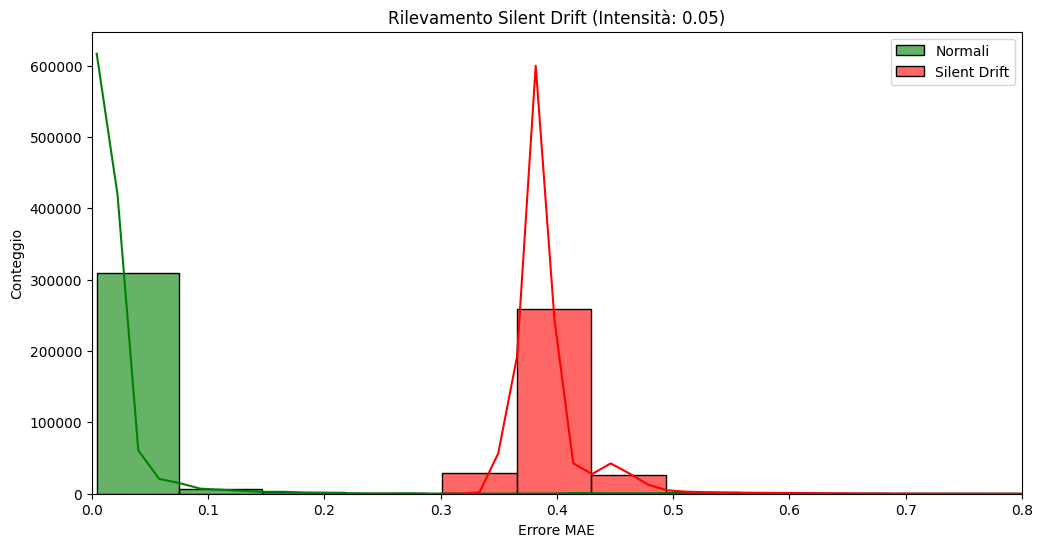

In [18]:
plt.figure(figsize=(12, 6))
sns.histplot(mae_per_sample[y_true == 0], color='green', label='Normali', kde=True, bins=50, alpha=0.6)
sns.histplot(mae_per_sample[y_true == 1], color='red', label='Silent Drift', kde=True, bins=50, alpha=0.6)

plt.xlim(0, 0.8) 

plt.title(f"Rilevamento Silent Drift (Intensità: {DRIFT_INTENSITY})")
plt.xlabel("Errore MAE")
plt.ylabel("Conteggio")
plt.legend()
plt.show()

#### Calcolo metriche

Soglia calcolata: 0.2229

--- RISULTATI CLASSIFICAZIONE (Silent Drift) ---
Accuracy:  0.9950
Precision: 0.9902
Recall:    1.0000
F1-Score:  0.9951


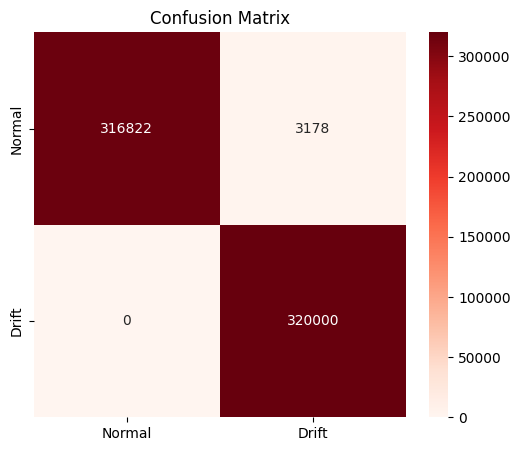

In [20]:
errori_normali = mae_per_sample[y_true == 0]
THRESHOLD = np.mean(errori_normali) + 3 * np.std(errori_normali)
print(f"Soglia calcolata: {THRESHOLD:.4f}")

y_pred = (mae_per_sample > THRESHOLD).astype(int)

print("\n--- RISULTATI CLASSIFICAZIONE (Silent Drift) ---")
print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
print(f"F1-Score:  {f1_score(y_true, y_pred):.4f}")

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['Normal', 'Drift'], yticklabels=['Normal', 'Drift'])
plt.title("Confusion Matrix")
plt.show()

#### Visualizzazione dell'attacco

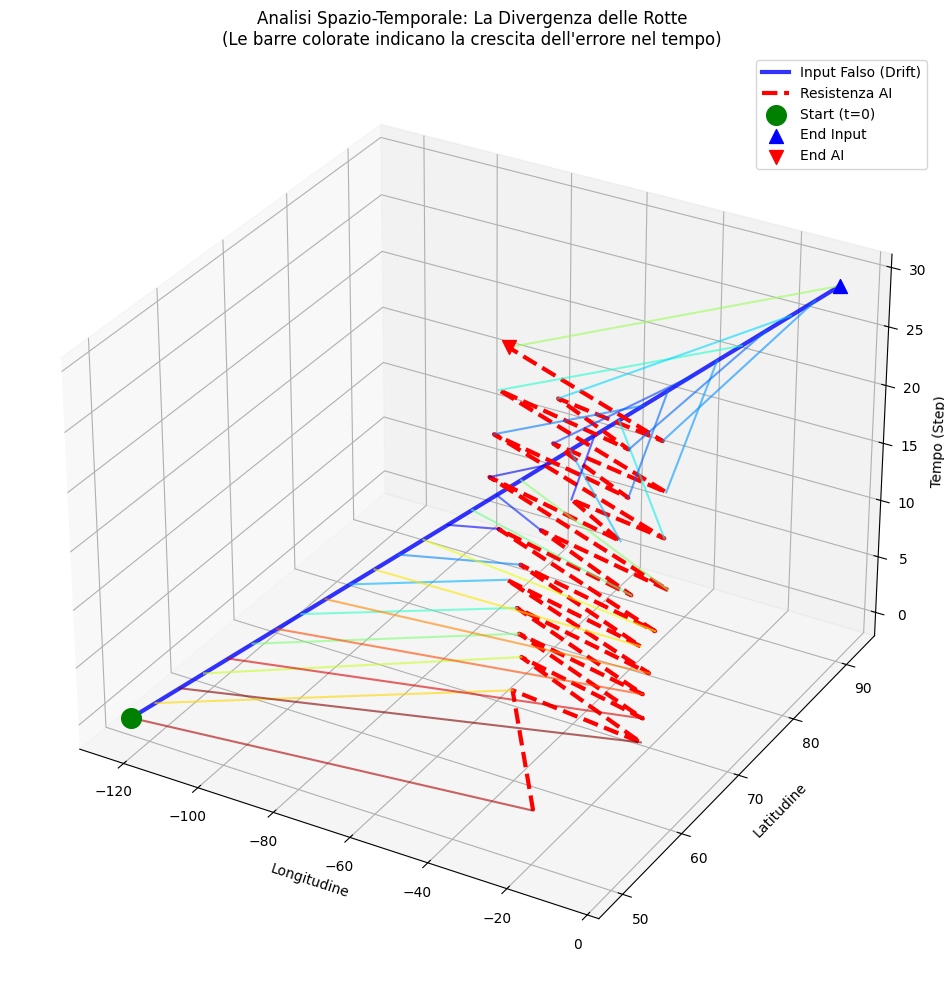

In [24]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

# --- PREPARAZIONE DATI (Drift Forte per visibilità) ---
clean_batch, _ = next(test_gen)
# Usiamo drift 0.20 per rendere la separazione evidente a occhio nudo
drift_batch = apply_silent_drift_attack(clean_batch, drift_rate=0.20) 
pred_batch = model.predict(drift_batch, verbose=0)

idx = 0
traj_input = drift_batch[idx] 
traj_recon = pred_batch[idx]  

# Denormalizziamo
traj_input_real = scaler.inverse_transform(traj_input)
traj_recon_real = scaler.inverse_transform(traj_recon)

# Dati per il plot
lat_in, lon_in = traj_input_real[:, 0], traj_input_real[:, 1]
lat_out, lon_out = traj_recon_real[:, 0], traj_recon_real[:, 1]
time_steps = np.arange(WINDOW_SIZE) # Asse Z (0..29)

# Calcolo distanza per colorare le connessioni
errors = np.sqrt((lat_in - lat_out)**2 + (lon_in - lon_out)**2)

# --- PLOT 3D: LA CERNIERA LAMPO ---
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

# 1. Disegniamo le due traiettorie che salgono nel tempo
# Linea Blu (Attacco)
ax.plot(lon_in, lat_in, time_steps, label='Input Falso (Drift)', color='blue', linewidth=3, alpha=0.8)
# Linea Rossa (AI)
ax.plot(lon_out, lat_out, time_steps, label='Resistenza AI', color='red', linewidth=3, linestyle='--')

# 2. Disegniamo le connessioni (l'Errore visibile)
# Creano l'effetto "scala" o "cerniera"
for t in range(WINDOW_SIZE):
    # Colore dinamico: Verde=Vicino, Rosso=Lontano
    color = plt.cm.jet(errors[t] / np.max(errors)) 
    ax.plot([lon_in[t], lon_out[t]], [lat_in[t], lat_out[t]], [t, t], color=color, linewidth=1.5, alpha=0.6)

# 3. Punti di Start e End
ax.scatter(lon_in[0], lat_in[0], 0, color='green', s=200, label='Start (t=0)', zorder=10)
ax.scatter(lon_in[-1], lat_in[-1], 29, color='blue', s=100, marker='^', label='End Input', zorder=10)
ax.scatter(lon_out[-1], lat_out[-1], 29, color='red', s=100, marker='v', label='End AI', zorder=10)

# Etichette e Titoli
ax.set_xlabel('Longitudine')
ax.set_ylabel('Latitudine')
ax.set_zlabel('Tempo (Step)')
ax.set_title('Analisi Spazio-Temporale: La Divergenza delle Rotte\n(Le barre colorate indicano la crescita dell\'errore nel tempo)')

# Vista dall'alto inclinata (per vedere bene la separazione)
ax.view_init(elev=30, azim=-60)

plt.legend()
plt.show()

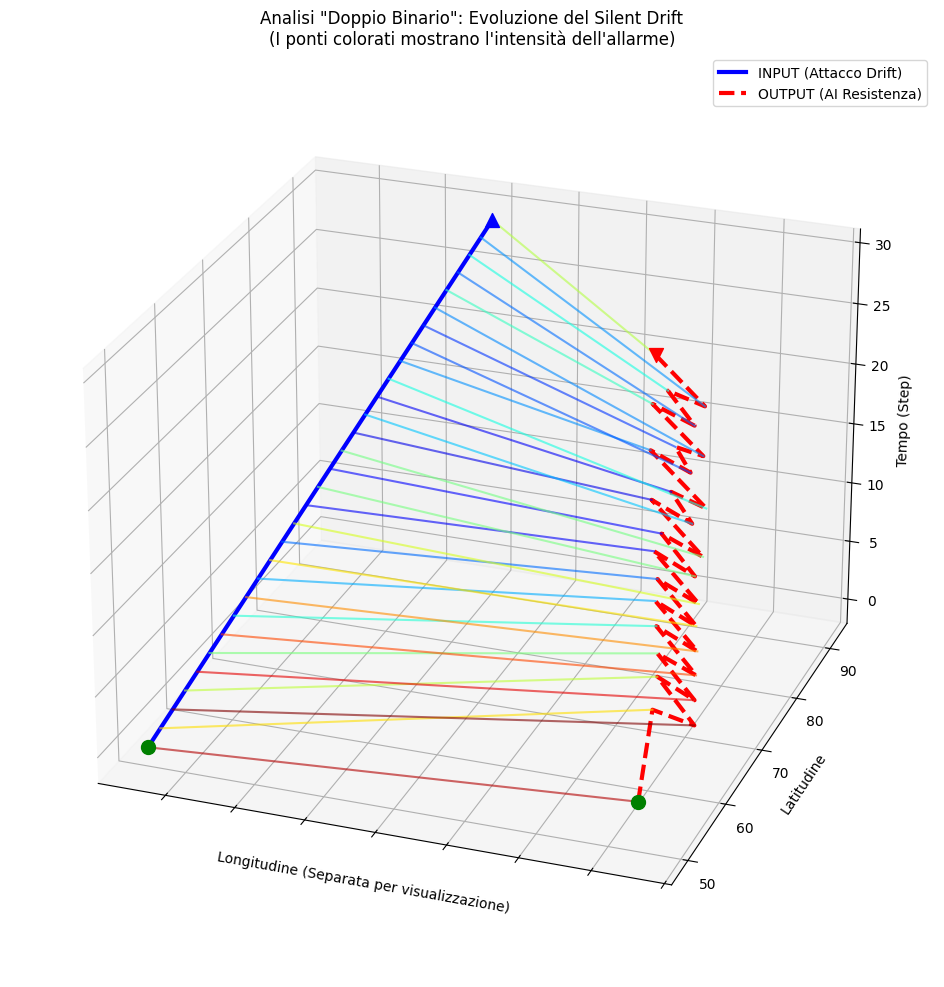

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np

# --- PREPARAZIONE DATI (Drift Forte) ---
clean_batch, _ = next(test_gen)
drift_batch = apply_silent_drift_attack(clean_batch, drift_rate=0.20)
pred_batch = model.predict(drift_batch, verbose=0)

idx = 0
traj_input = drift_batch[idx] 
traj_recon = pred_batch[idx]  

# Denormalizziamo
traj_input_real = scaler.inverse_transform(traj_input)
traj_recon_real = scaler.inverse_transform(traj_recon)

# Coordinate
lat_in, lon_in = traj_input_real[:, 0], traj_input_real[:, 1]
lat_out, lon_out = traj_recon_real[:, 0], traj_recon_real[:, 1]
time_steps = np.arange(WINDOW_SIZE)

# Calcolo Errore Reale (Distanza Euclidea in gradi) per ogni step
true_errors = np.sqrt((lat_in - lat_out)**2 + (lon_in - lon_out)**2)

# Offset per la visualizzazione split
offset_lon = (np.max(lon_in) - np.min(lon_in)) * 2.0 
if offset_lon < 0.05: offset_lon = 0.05
lon_out_shifted = lon_out + offset_lon

# --- LAYOUT GRAFICO (2 Pannelli) ---
fig = plt.figure(figsize=(18, 8))

# --- PANNELLO 1: 3D SPLIT VIEW ---
ax = fig.add_subplot(1, 2, 1, projection='3d')

# Traccia Input
ax.plot(lon_in, lat_in, time_steps, color='blue', linewidth=3, label='Input (Attacco)')
ax.scatter(lon_in[0], lat_in[0], 0, color='green', s=100)
ax.scatter(lon_in[-1], lat_in[-1], 29, color='blue', s=100, marker='^')

# Traccia AI (Spostata)
ax.plot(lon_out_shifted, lat_out, time_steps, color='red', linewidth=3, linestyle='--', label='AI (Resistenza)')
ax.scatter(lon_out_shifted[0], lat_out[0], 0, color='green', s=100)
ax.scatter(lon_out_shifted[-1], lat_out[-1], 29, color='red', s=100, marker='v')

# Ponti Colorati con Mappatura Corretta
norm = colors.Normalize(vmin=np.min(true_errors), vmax=np.max(true_errors))
cmap = plt.cm.jet

for t in range(WINDOW_SIZE):
    color = cmap(norm(true_errors[t]))
    ax.plot([lon_in[t], lon_out_shifted[t]], 
            [lat_in[t], lat_out[t]], 
            [t, t], 
            color=color, linewidth=2, alpha=0.7)

# Etichette 3D
ax.set_xlabel('Longitudine (Split)')
ax.set_ylabel('Latitudine')
ax.set_zlabel('Tempo (Step)')
ax.set_title('Visualizzazione 3D: Evoluzione del Silent Drift')
ax.set_xticklabels([]) # Rimuovi tick X confusi
ax.view_init(elev=30, azim=-60)
ax.legend()

# --- PANNELLO 2: ANALISI QUANTITATIVA ERRORE ---
ax2 = fig.add_subplot(1, 2, 2)
# Plot della curva di errore
ax2.plot(time_steps, true_errors, marker='o', linestyle='-', color='purple', linewidth=2, label='Errore Istantaneo')
# Riempimento sfumato sotto la curva
ax2.fill_between(time_steps, true_errors, color='purple', alpha=0.1)

# Aggiungi la soglia media (opzionale, per contesto)
ax2.axhline(y=0.029, color='green', linestyle='--', label='Soglia di Allarme (0.029)')

ax2.set_title("Dinamica dell'Errore nel Tempo")
ax2.set_xlabel("Tempo (Step)")
ax2.set_ylabel("Errore di Ricostruzione (Gradi)")
ax2.grid(True, alpha=0.3)
ax2.legend()

# --- COLORBAR CONDIVISA ---
# Aggiungiamo la barra dei colori al centro/destra
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, shrink=0.5, aspect=10, pad=0.1)
cbar.set_label('Intensità Errore (Distanza)')

plt.tight_layout()
plt.show()